In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import requests

### Using Homographies for camera pose estimation

This notebook shows how you can use a homography to perform camera pose estimation, in the simple case where you only undergo in plane translation and rotation. This could be useful if you have a drone taking photos from high above the ground, for image registration in remote sensing applications, or if you have a robot pointing a camera at the ceiling. This notebook refers to material covered in Week 3 and Week 4.

In [12]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    return cv2.cvtColor(np.array(img),cv2.COLOR_BGR2GRAY)

im = read_image_from_url('https://www.aboriginal-art-australia.com/wp-content/uploads/2023/09/DLP148-1-294x300.jpg')

# Rotate 27 degrees, tranlate -15,5 pixels
th = 27*np.pi/180
tx=-15
ty =5
M = np.array([[np.cos(th),-np.sin(th),tx],
             [np.sin(th),np.cos(th),ty],
              [0,0,1]])
# Simulate the change in view that would we would undero given this transformation
im_new = cv2.warpPerspective(im,M,im.shape,borderMode=0)

Many of our lectures speak about perspective effects, drawing on renaissance art to illustrate this. As we have learned, these create constraints that we can exploit in computer vision. I recently learned that the aerial perspective is an important stylistic and storytelling tool in [Indigenous Australian artwork](https://www.aboriginal-art-australia.com/aboriginal-art-library/aerial-perspectives-in-aboriginal-art/), with bird-eye-view imagery much more common than perspective effects. Let's look at how to exploit the constraints associated with birds-eye-view images like these.

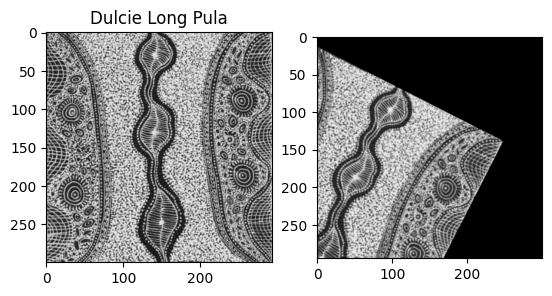

In [13]:
plt.subplot(1,2,1)
plt.imshow(im,cmap='gray')
plt.title('Dulcie Long Pula')
plt.subplot(1,2,2)
plt.imshow(im_new,cmap='gray')
plt.show()

In [14]:
# Initiate ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(im,None)
kp2, des2 = orb.detectAndCompute(im_new,None)

In [15]:
# Match keypoints
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

In [16]:
# Sort matches
matches = sorted(matches, key = lambda x:x.distance)

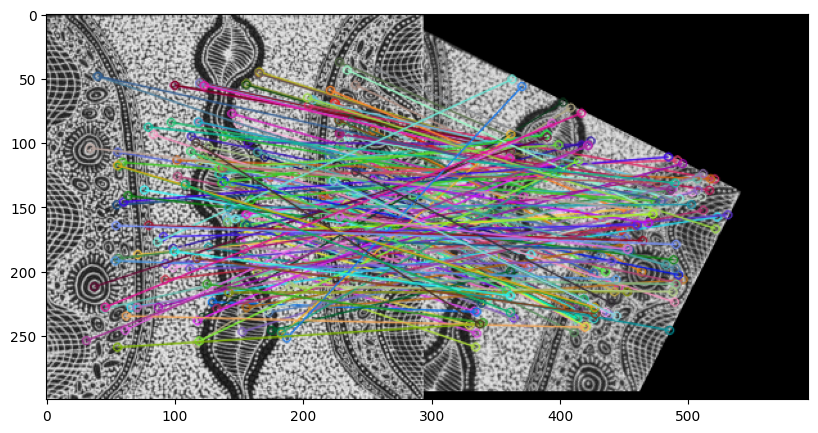

In [17]:
# Draw first 20 matches.
plt.figure(figsize=(15,5))
img3 = cv2.drawMatches(im,kp1,im_new,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [18]:
# Find keypoint correspondences
X1 = np.vstack([kp1[match.queryIdx].pt for match in matches])
X2 = np.vstack([kp2[match.trainIdx].pt for match in matches])

# Estimate homograpahy using opencv -
H, mask = cv2.findHomography(X1, X2, cv2.RANSAC, 1.0)

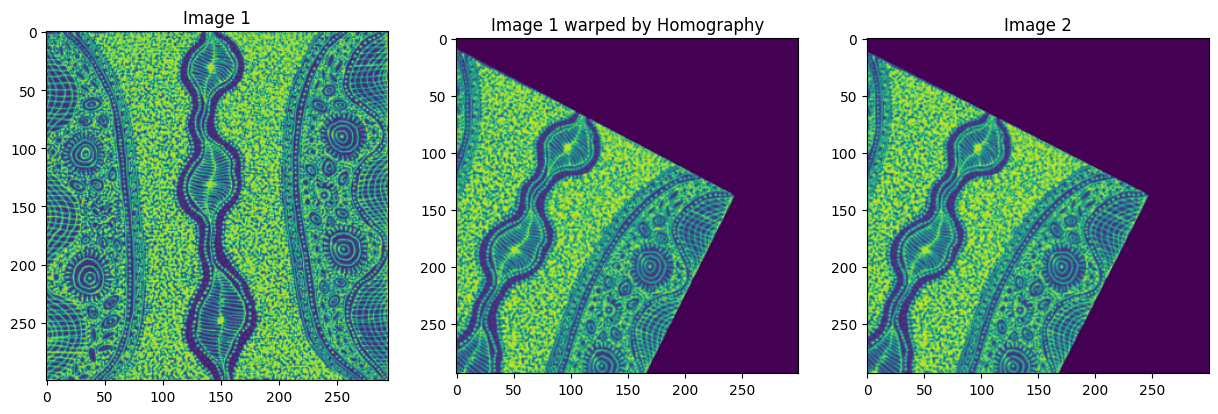

In [19]:
# Lets apply the homography to our image - in theory it should generate the second picture
im_warp = cv2.warpPerspective(im,H,(im.shape[0],im.shape[1]))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Image 1')
plt.subplot(1,3,2)
plt.imshow(im_warp)
plt.title('Image 1 warped by Homography')
plt.subplot(1,3,3)
plt.imshow(im_new)
plt.title('Image 2')
plt.show()

### Decomposing a homography

A homography is a representation of a planes rotation and translation (up to scale). This can be decomposed to determine how a camera has moved from one frame to another (or how an object in a scene has moved between frames). Let's consider the case of a pure rotation in plane rotation and translation. This is the kind of motion we may see if a robot is moving and looking up at a ceiling, or in a remote sensing application where a camera is pointing down.

Recall that we covered image invariances we saw that an affine map that produces rotation and translation takes the form:

$\mathbf{a} = \begin{bmatrix} \cos\theta & -\sin\theta & x\\ \sin\theta & \cos\theta & y\\ 0 & 0 & 1 \end{bmatrix} $

Our homography matrix should look similar.

In [ ]:
print('H',H)
print('Map', M)

Note that this is basically the same as the affine map we generated earlier. Lets extract the rotation angle and translation.

In [ ]:
print ('The angle of rotation is %2.2f degrees.'%(np.arctan2(H[0,1],H[0,0])*180/np.pi))
print ('The translation is x=%2.2f, y=%2.2f pixels'%(H[0,2],H[1,2]))

Yes. It worked, up to scale. We don't know how many pixels correspond to metres, unless we calibrate our camera.